# Loading the dataset

## Transformations

1. **RandomRotation**: Randomly rotate the image by up to *15* degrees
2. **CenterCrop**: Crop the center region of the image to size *178x178*
3. **ColorJitter**: Apply random color jittering
4. **RandomHorizontalFlip**: Randomly flip the image on the Y axis, with a *50%* chance
5. **ToImage**: Converts the PIL Images to torchvision Images
6. **ToDtype**: Convert the image to the given datatype (*torch.float32*) and scale pixel values to **[0, 1]**

There is a seperate normal_transformation used for the test and validation datasets, where augmentation is not needed.

## Initializing the dataset

- **DTYPE**: torch.float32 by default, during training autocast is applied to speed up training
- **DOWNLOAD**: True by default, this is to be set to False in case the dataset can be provided by a manual upload 

In [1]:
import torch
from torchvision.datasets import CelebA
from torchvision.transforms.v2 import (
    CenterCrop,
    ColorJitter,
    Compose,
    InterpolationMode,
    RandomHorizontalFlip,
    RandomRotation,
    ToDtype,
    ToImage,
)

# Initial datatype of the images, will be converted by autocast later
DTYPE = torch.float32
# Download the dataset if it is not already downloaded
DOWNLOAD = False

train_transform = Compose(
    [
        # RandomRotation(15, interpolation=InterpolationMode.BILINEAR),
        CenterCrop(178),
        ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        RandomHorizontalFlip(),
        ToImage(),
        ToDtype(dtype=DTYPE, scale=True),
    ]
)

normal_transform = Compose([CenterCrop(178), ToImage(), ToDtype(DTYPE, scale=True)])

train = CelebA("data", "train", download=DOWNLOAD, transform=train_transform)
# valid = CelebA("data", "valid", download=DOWNLOAD, transform=normal_transform)
test = CelebA("data", "test", download=DOWNLOAD, transform=normal_transform)

Number of pictures: 162770
Number of attributes: 40
Attribute names: 5_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young
Resolution: 178x178


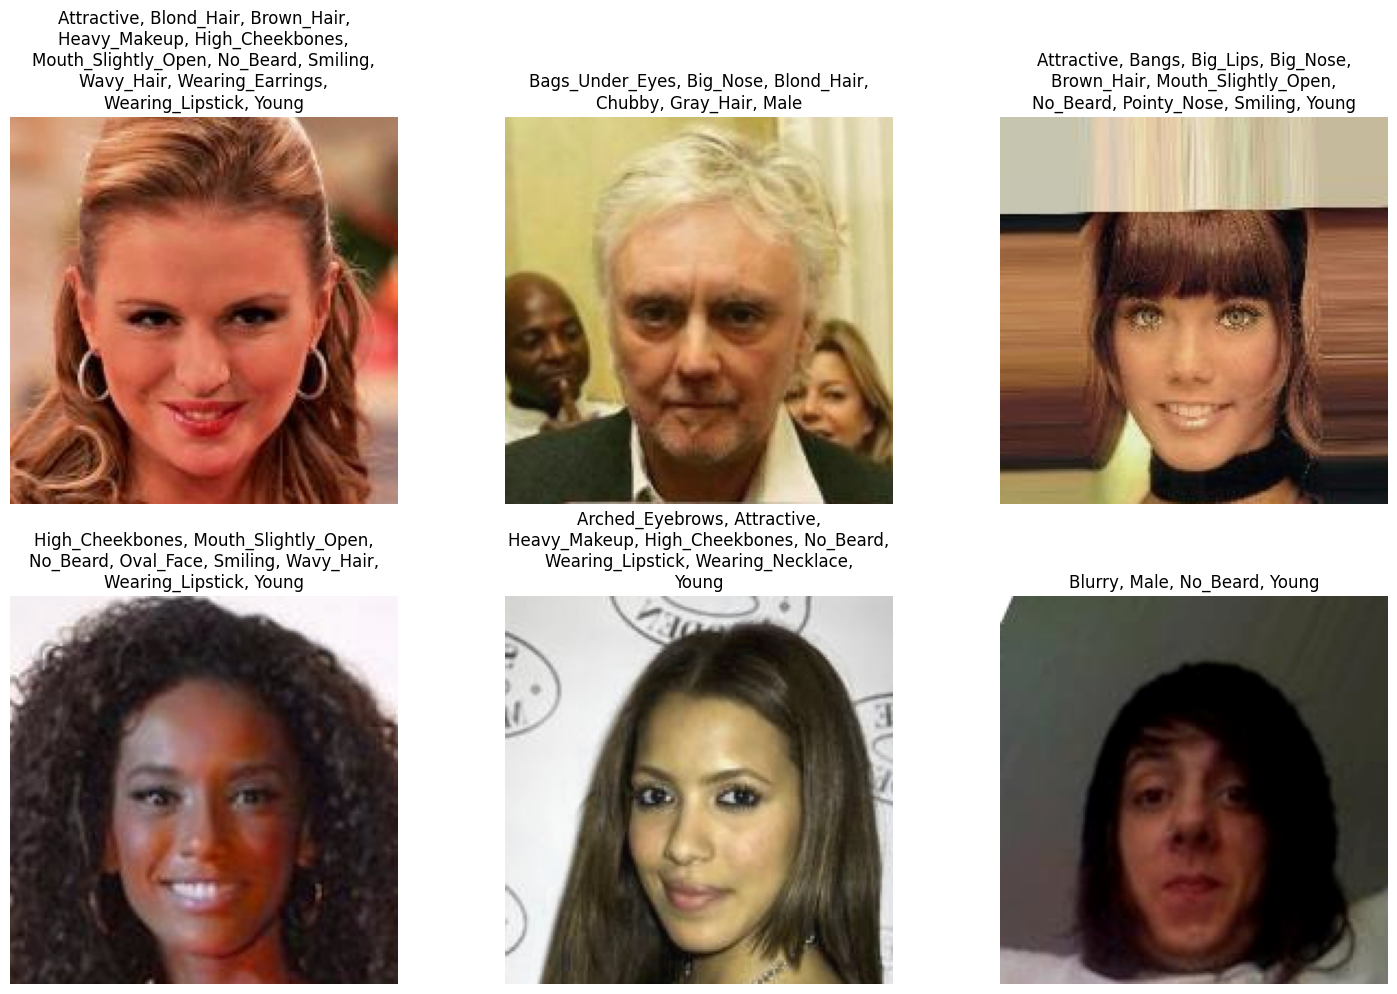

In [2]:
import random
import textwrap

import matplotlib.pyplot as plt

ATTRIBUTES = train.attr_names[:-1]

print(f"Number of pictures: {len(train)}")

print(f"Number of attributes: {len(ATTRIBUTES)}")

print(f"Attribute names: {', '.join(ATTRIBUTES)}")

shape = train[0][0].shape
print(f"Resolution: {shape[1]}x{shape[2]}")

# Define the number of rows and columns for the grid of images
ROWS = 2
COLS = 3

# Create subplots
fig, axs = plt.subplots(ROWS, COLS, figsize=(5 * COLS, 5 * ROWS))

# Randomly select images
selected_images = random.sample(range(len(train)), ROWS * COLS)

for i in range(ROWS * COLS):
    # Get attributes for the current image
    attrs = [
        attr
        for j, attr in enumerate(train.attr_names[:-1])
        if train[selected_images[i]][1][j] == 1
    ]

    # Calculate the row and column indices for the current image
    row = i // COLS
    col = i % COLS

    # Display the image
    axs[row, col].imshow(train[selected_images[i]][0].permute(1, 2, 0))

    # Remove the axes
    axs[row, col].axis("off")

    # Set the title to the attributes, with line breaks
    title = ", ".join(attrs)
    axs[row, col].set_title(textwrap.fill(title, 40))

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
from mymodel import NEW_ATTRIBUTES

MAPPING = torch.IntTensor([ATTRIBUTES.index(attribute) for attribute in NEW_ATTRIBUTES])


def transform_y(y: torch.Tensor):
    """Transforms the input y (label) by applying the mapping from old to new attributes.
    This is needed, because the FFN head of the model has a different ordering of attributes.

    Args:
        y (torch.Tensor): The input tensor of shape (batch_size, num_attributes).

    Returns:
        torch.Tensor: The transformed tensor of shape (batch_size, num_selected_attributes).
    """
    return y.index_select(1, MAPPING)

/home/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from mymodel import MyModel
from torch import nn, optim
from torch.nn import BCELoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader


def train_loop(
    dataloader: DataLoader,
    model: MyModel,
    loss_fn: BCELoss,
    optimizer: Optimizer,
    device: str = "cpu",
    epochs=5,
):
    size = len(dataloader.dataset)
    model.train()
    for epoch in range(1, epochs + 1):
        avg_loss = 0
        for batch_number, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device=device, dtype=DTYPE)
            y = transform_y(y)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()

            if batch_number > 0 and batch_number % 100 == 0:
                current_batch = batch_number * model.batch_size + len(x)
                avg_loss /= 100  # normalize over the last 100 batches
                done = current_batch * 100 / size
                print(f"Epoch: {epoch}/{epochs} loss: {avg_loss:>7f}  [{done:.2f}%]")
                avg_loss = 0

In [5]:
from torch import cuda, mps

device = "cuda" if cuda.is_available() else "mps" if mps.is_available() else "cpu"
print(f"Using device: {device}")

MAPPING = MAPPING.to(device)

BATCH_SIZE = 64

model = MyModel(batch_size=BATCH_SIZE).to(device)

Using device: cuda


In [6]:
from torch import save

loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters())

train_loader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    pin_memory_device=device,
)
# valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)

train_loop(train_loader, model, loss_fn, optimizer, device, epochs=3)
save(model.state_dict(), "./data/trained.pth")

Epoch: 1/3 loss: 0.425680  [3.97%]
Epoch: 1/3 loss: 0.351495  [7.90%]
Epoch: 1/3 loss: 0.302132  [11.84%]
Epoch: 1/3 loss: 0.280088  [15.77%]
Epoch: 1/3 loss: 0.269877  [19.70%]
Epoch: 1/3 loss: 0.261377  [23.63%]
Epoch: 1/3 loss: 0.253401  [27.56%]
Epoch: 1/3 loss: 0.251783  [31.49%]
Epoch: 1/3 loss: 0.245202  [35.43%]
Epoch: 1/3 loss: 0.240854  [39.36%]
Epoch: 1/3 loss: 0.237726  [43.29%]
Epoch: 1/3 loss: 0.235798  [47.22%]
Epoch: 1/3 loss: 0.233713  [51.15%]
Epoch: 1/3 loss: 0.233553  [55.09%]
Epoch: 1/3 loss: 0.230627  [59.02%]
Epoch: 1/3 loss: 0.226914  [62.95%]
Epoch: 1/3 loss: 0.225137  [66.88%]
Epoch: 1/3 loss: 0.223803  [70.81%]
Epoch: 1/3 loss: 0.223840  [74.75%]
Epoch: 1/3 loss: 0.222559  [78.68%]
Epoch: 1/3 loss: 0.220084  [82.61%]
Epoch: 1/3 loss: 0.219059  [86.54%]
Epoch: 1/3 loss: 0.216501  [90.47%]
Epoch: 1/3 loss: 0.218892  [94.41%]
Epoch: 1/3 loss: 0.217406  [98.34%]
Epoch: 2/3 loss: 0.216239  [3.97%]
Epoch: 2/3 loss: 0.213784  [7.90%]
Epoch: 2/3 loss: 0.212797  [11.8

In [7]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    correct_attributes = [0] * 40
    baseline = [0] * 40

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device=device, dtype=DTYPE)
            y = transform_y(y)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            pred_binary = (pred > 0.5).type(torch.float)
            correct += (
                ((pred_binary == y) & (y == 0) | (pred_binary == y) & (y == 1))
                .type(torch.float)
                .sum()
                .item()
            )
            correct_attributes += (
                (pred_binary == y).type(torch.float).sum(dim=0).cpu().numpy()
            )
            baseline += y.sum(dim=0).cpu().numpy()

    test_loss /= num_batches
    correct /= num_batches * model.batch_size * 40
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    return (
        correct_attributes / (num_batches * model.batch_size),
        baseline / (num_batches * model.batch_size),
    )

In [8]:
from torch import load

model = MyModel(batch_size=BATCH_SIZE)
model.load_state_dict(load("./data/trained.pth"))
model.to(device)

test_loader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    pin_memory_device=device,
)

attribute_accuracy, baseline = test_loop(test_loader, model, loss_fn, device)
baseline = [item if item > 0.5 else 1 - item for item in baseline]

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.205596 



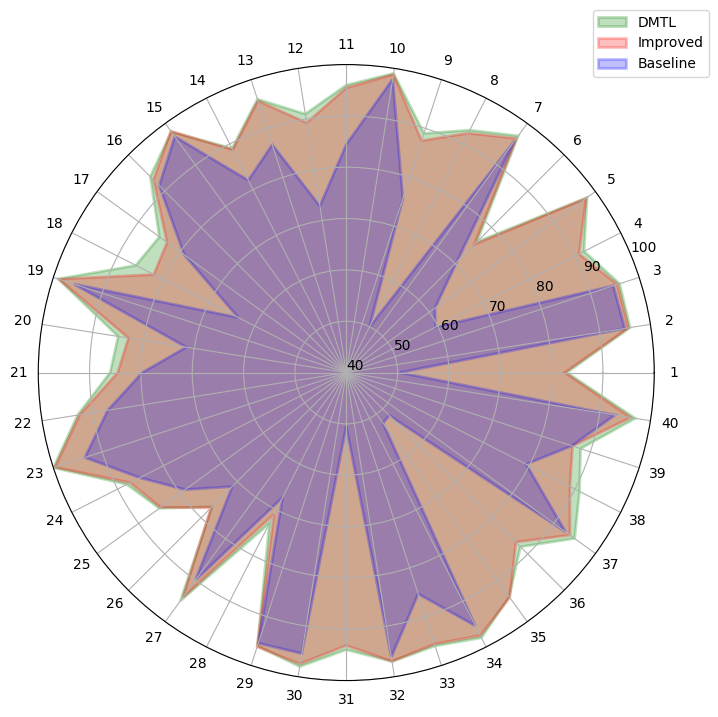

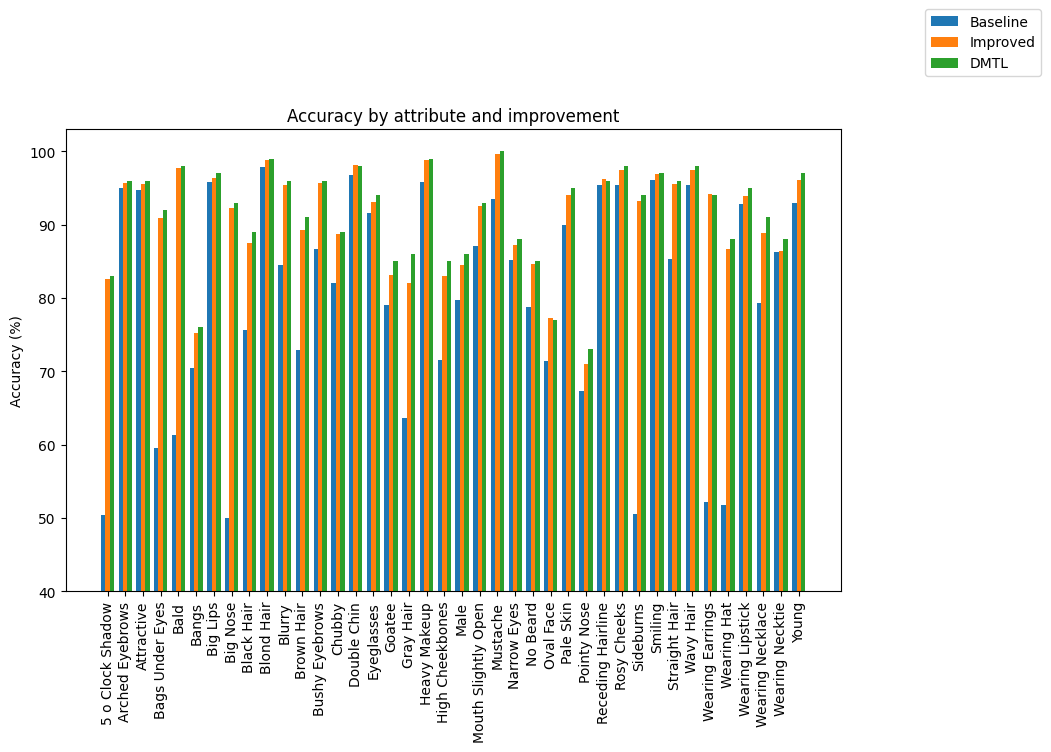

In [10]:
import matplotlib.pyplot as plt
import numpy as np

labels = [label.replace("_", " ") for label in ATTRIBUTES]

DMTL = [
    0.83,
    0.96,
    0.96,
    0.92,
    0.98,
    0.76,
    0.97,
    0.93,
    0.89,
    0.99,
    0.96,
    0.91,
    0.96,
    0.89,
    0.98,
    0.94,
    0.85,
    0.86,
    0.99,
    0.85,
    0.86,
    0.93,
    1.0,
    0.88,
    0.85,
    0.77,
    0.95,
    0.73,
    0.96,
    0.98,
    0.94,
    0.97,
    0.96,
    0.98,
    0.94,
    0.88,
    0.95,
    0.91,
    0.88,
    0.97,
]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(
    angles,
    [i - 0.4 for i in DMTL],
    color="green",
    alpha=0.25,
    edgecolor="green",
    linewidth=2,
)
ax.fill(
    angles,
    [i - 0.4 for i in attribute_accuracy],
    color="red",
    alpha=0.25,
    edgecolor="red",
    linewidth=2,
)
ax.fill(
    angles,
    [i - 0.4 for i in baseline],
    color="blue",
    alpha=0.25,
    edgecolor="blue",
    linewidth=2,
)

ax.set_rmax(0.6)
ax.set_rticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(angles)
# ax.set_xticklabels([f"{label}: {attribute_accuracy[i]*100:.2f}%" for i, label in enumerate(labels)])
ax.set_xticks(angles)
ax.set_xticklabels([f"{i+1}" for i in range(len(labels))])  # Change labels to index+1


# Add a legend to the polar plot
ax.legend(
    ["DMTL", "Improved", "Baseline"], loc="upper right", bbox_to_anchor=(1.1, 1.1)
)

plt.show()


improved = attribute_accuracy

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, [i - 0.4 for i in baseline], width, label="Baseline")
rects2 = ax.bar(x, [i - 0.4 for i in improved], width, label="Improved")
rects3 = ax.bar(x + width, [i - 0.4 for i in DMTL], width, label="DMTL")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy by attribute and improvement")
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_yticklabels([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
# Add a legend to the bar plot
ax.legend(["Baseline", "Improved", "DMTL"], loc="lower left", bbox_to_anchor=(1.1, 1.1))


plt.show()

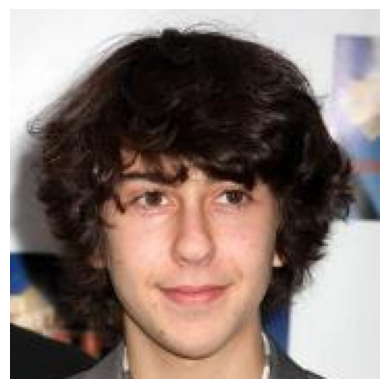

actual attributes: Attractive, Bangs, Black_Hair, Bushy_Eyebrows, Male, No_Beard, Oval_Face, Smiling, Wavy_Hair, Young
expected attributes: Attractive, Bangs, Black_Hair, Male, No_Beard, Oval_Face, Smiling, Wavy_Hair, Young


In [13]:
SAMPLE = 123

example = test[SAMPLE][0]

plt.imshow(example.permute(1, 2, 0))
plt.axis("off")
plt.show()

output = model.forward(example.unsqueeze(0).to(device))

actual = sorted((attr for i, attr in enumerate(NEW_ATTRIBUTES) if output[0][i] > 0.5))
print(f"actual attributes: {', '.join(actual)}")

expected = sorted(
    (attr for i, attr in enumerate(ATTRIBUTES) if test[SAMPLE][1][i] == 1)
)
print(f"expected attributes: {', '.join(expected)}")

In [8]:
import coremltools as ct
import torch

example = example.unsqueeze(0).to(device)


@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)


traced_model = trace(model, example)

coreml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape, name="input")],
    outputs=[ct.TensorType(name="attribute_labels")],
)

coreml_model.input_description["input"] = "Input image"
coreml_model.output_description["attribute_labels"] = "Output attributes"
coreml_model.author = "Szenyán Zsombor"
coreml_model.license = "MIT"
coreml_model.short_description = (
    "A model that predicts facial attributes of a person in an image."
)
coreml_model.version = "0.1"

# Save the converted model.
coreml_model.save("newmodel.mlpackage")
traced_model.save("newmodel.pt")

Torch version 2.2.1+cu121 has not been tested with coremltools. You may run into unexpected errors. Torch 2.1.0 is the most recent version that has been tested.
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 184.00 passes/s]
